In [1]:
import os
import pandas as pd
import xarray as xr
import geopandas as gpd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from shapely.geometry.polygon import Polygon
import folium


In [2]:
path_rap = "/glade/p/cisl/aiml/conv_risk_intel/rap_ncei_nc/"
path_save = "/glade/p/cisl/aiml/jtti_tornado/rap_contours/"


In [11]:
date = '20070524'
gdf = gpd.read_file(os.path.join(path_save, f'{date}.geojson'), driver='GeoJSON')  
print(gdf.shape)
gdf.head(5)


(235, 4)


,date,hour,intensity,geometry
0,20070524,00,1.000000e-12,"POLYGON ((-126.25267 16.75031, -126.10141 16.6..."
1,20070524,00,1.000000e-12,"POLYGON ((-126.69016 18.51397, -126.69016 18.5..."
2,20070524,00,1.000000e-12,"POLYGON ((-127.01870 19.81037, -126.86327 19.7..."
3,20070524,00,1.000000e-12,"POLYGON ((-136.11324 46.93978, -135.95612 46.9..."
4,20070524,00,1.000000e-12,"POLYGON ((-122.07940 17.12876, -122.10447 17.2..."


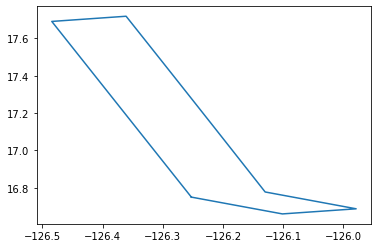

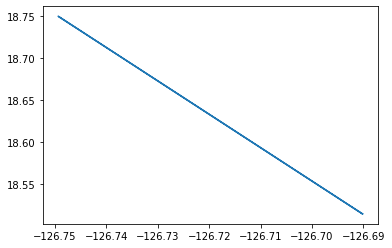

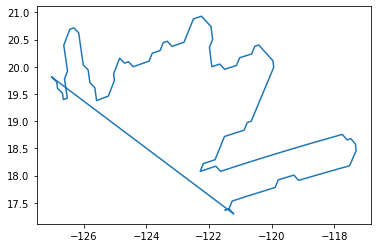

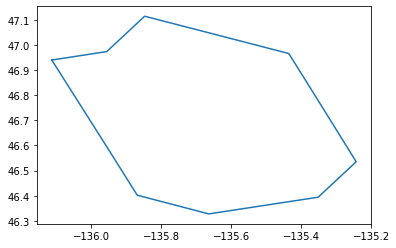

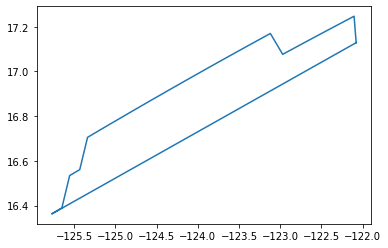

In [4]:
for i in range(gdf.shape[0])[:5]:
    x,y = gdf['geometry'][i].exterior.xy
    plt.plot(x,y)
    plt.show()


In [13]:
m = folium.Map(location=[40, -100], zoom_start=4, tiles='CartoDB positron')
for _, r in gdf.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['intensity']).add_to(geo_j)
    geo_j.add_to(m)
m


In [7]:
hours = [f[-11:-9] for f in os.listdir(os.path.join(path_rap, date)) if f.endswith('.nc')]
try:
    ds = xr.open_dataset(os.path.join(path_rap, date, f"rap_130_{date}_{hours[0]}00_000.nc"))
except:
    ds = xr.open_dataset(os.path.join(path_rap, date, f"ruc2anl_130_{date}_{hours[0]}00_000.nc"))

sbcape = ds.sel(press=1000).to_dataframe()['SBCAPE'].unstack('y').values
print(sbcape.min())
print(sbcape.max())


0.0
6481.0


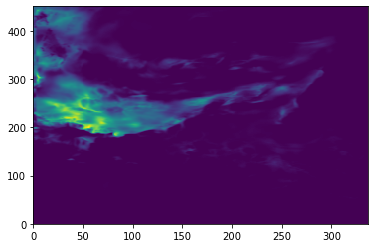

In [8]:
plt.pcolormesh(sbcape)

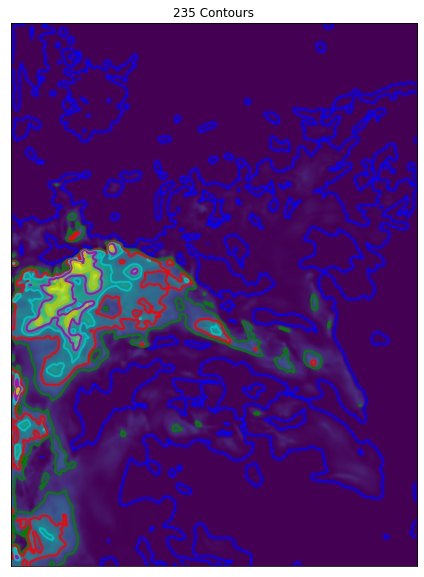

In [15]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']
fig, ax = plt.subplots(figsize=(8,10))
ax.imshow(sbcape)
contour_count =0
for i,intensity in enumerate([1e-12,1000,2000,3000,4000,5000]):
    contours = measure.find_contours(sbcape, intensity)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color=colors[i])
        contour_count += 1
ax.set_title(f'{contour_count} Contours')
ax.set_xticks([])
ax.set_yticks([])
plt.show()
